# 2層のニューラルネットワーク

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from collections import OrderedDict

### ソフトマックス関数（出力層：分類問題）
$ y_k = \frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)} $

In [31]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)  # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

### 交差エントロピー誤差（損失関数）
$ E = -\sum_{k}^{n}t_k log(y_k) $

In [32]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### Affine レイヤ

In [33]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

### ReLU レイヤ（活性化関数）
$ y = \begin{cases}
          x \quad (x > 0) \\
          0 \quad (x \leqq 0) \\
      \end{cases} $

In [34]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

### Softmax-with-Loss レイヤ（出力層 + 損失関数）

In [35]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

### MNIST データセット

In [36]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print("x_train.shape [N, H * W]:", x_train.shape)
print("t_train.shape:", t_train.shape, t_train.dtype)

x_train.shape [N, H * W]: (60000, 784)
t_train.shape: (60000, 10) float64


#### 【オプション】入力データの確認

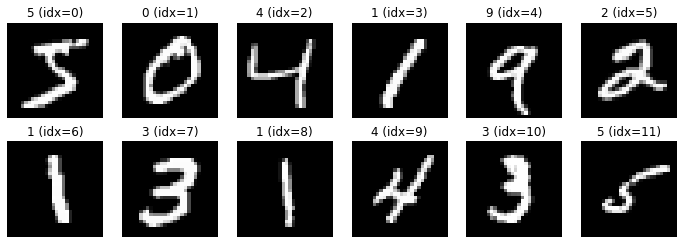

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [37]:
# 画像を表示
figure = plt.figure(figsize=(12, 4))
rows, cols = 2, 6
for i in range(rows * cols):
    img, label = x_train[i], t_train[i].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label} (idx={i})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 784 -> 28x28 に変換
    plt.imshow(img, cmap='gray')
plt.show()
print(t_train[:rows * cols])

### ニューラルネットワークの定義

In [38]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

### ニューラルネットワークのインスタンス化

In [39]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
print(network)

### パラメータの定義

In [40]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

### ミニバッチの学習

In [41]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

train_size = x_train.shape[0]  # 訓練データの数
iter_per_epoch = max(int(train_size / batch_size), 1)  # エポック毎の繰り返しの回数
iters_num = iter_per_epoch * epoch_num  # 全体の繰り返しの回数

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % iter_per_epoch == 0:
        epoch_count = int((i + 1) / iter_per_epoch)
        #print(f'epoch({epoch_count}) loss = {train_loss_list[-1]}')
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'epoch({epoch_count}) accuracy(train, test) = ({train_acc}, {test_acc})')

print('Done!')

epoch(1) accuracy(train, test) = (0.9052333333333333, 0.9075)
epoch(2) accuracy(train, test) = (0.9220333333333334, 0.9248)
epoch(3) accuracy(train, test) = (0.9319833333333334, 0.9322)
epoch(4) accuracy(train, test) = (0.9449333333333333, 0.9433)
epoch(5) accuracy(train, test) = (0.9530833333333333, 0.9507)
epoch(6) accuracy(train, test) = (0.9571833333333334, 0.9547)
epoch(7) accuracy(train, test) = (0.96145, 0.9581)
epoch(8) accuracy(train, test) = (0.9651, 0.9613)
epoch(9) accuracy(train, test) = (0.9673, 0.9629)
epoch(10) accuracy(train, test) = (0.9697166666666667, 0.9635)
epoch(11) accuracy(train, test) = (0.9717833333333333, 0.965)
epoch(12) accuracy(train, test) = (0.9724166666666667, 0.9638)
epoch(13) accuracy(train, test) = (0.9755166666666667, 0.967)
epoch(14) accuracy(train, test) = (0.9768166666666667, 0.9685)
epoch(15) accuracy(train, test) = (0.9776, 0.9686)
epoch(16) accuracy(train, test) = (0.97945, 0.969)
epoch(17) accuracy(train, test) = (0.9792166666666666, 0.9699)

### 損失関数の推移

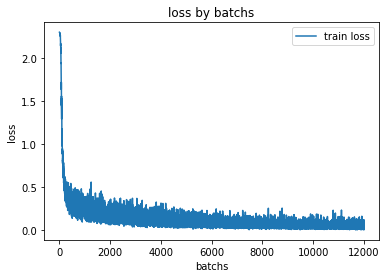

In [42]:
# グラフの描画
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

### 認識精度の推移

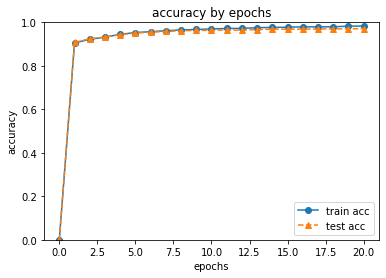

In [43]:
# グラフの描画
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 【オプション】テストの結果

In [44]:
# テストの実行
test_predict = network.predict(x_test)
print(test_predict.shape)
for index in range(3):
    print(f'index = {index}')
    print(test_predict[index])
    print(t_test[index])

(10000, 10)
index = 0
[ 7.15426543e-01 -5.02936698e+00  4.22919290e+00  5.34876626e+00
 -6.12803605e+00 -3.08732654e+00 -1.26923894e+01  1.51111870e+01
 -1.40316315e-02  1.99303628e+00]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
index = 1
[  2.72281131   4.46114706  15.00719402   6.04891804 -17.57513912
   2.98675472   5.65536882  -6.33451254   3.26905072 -16.62855947]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index = 2
[-5.76652923  8.09179031  1.1356035  -1.48184797  0.12032946 -1.73123677
 -0.27770464  1.5675541   1.19052906 -2.32920062]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


#### 【オプション】エラー結果の確認

error rate = 2.85[%]


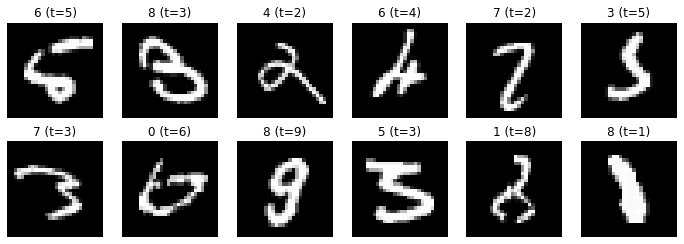

In [45]:
# エラー結果の要素を抽出
index_error = np.argmax(test_predict, axis=1) != np.argmax(t_test, axis=1)
error_list = np.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]')

# 画像を表示
figure = plt.figure(figsize=(12, 4))
rows, cols = 2, 6
for i in range(rows * cols):
    index = error_list[i]
    img, label_t, label_y = x_test[index], t_test[index].argmax(), test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 784 -> 28x28 に変換
    plt.imshow(img, cmap='gray')
plt.show()